# CMIP

## Downloading data

In [1]:
import xarray as xr
import atlite
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd


Chile = gpd.read_file('Chile.geojson')
Chile = Chile.set_index('region')
bounds = Chile.unary_union.buffer(1).bounds
# set lat and lon
x1 = bounds[0]
y1 = bounds[1]
x2 = bounds[2]
y2 = bounds[3]

# configuration parameter

exp_id = "historical"

esgf_params = {
   'data_node': 'esgf.ceda.ac.uk',
   'source_id': 'HadGEM3-GC31-MM',
   'variant_label':'r1i1p1f3',
   'experiment_id': exp_id,
   'project' : 'CMIP6'}




# years for cmip6
cmipyears = range(2010,2016)


for year in cmipyears:
    print(year)
    filename = "./data/cmip-"+exp_id+"/cmip_chile_"+str(year)+".nc"
    # read cmip files
    cutout_cmip = atlite.Cutout(path=filename,
                                module=["cmip"], 
                                x=slice(x1,x2), 
                                y=slice(y1,y2), 
                                time=str(year), 
                                esgf_params=esgf_params, 
                                dt='3H', dx=1,dy=1)
    cutout_cmip.prepare()

2010



-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------

----------------------------------------------------

ValueError: No results found in the ESGF_database

## Calculating generation data
### For Chile

In [ ]:
#from atlite.datasets.era5 import retrieve_data, _rename_and_clean_coords, retrieval_times, _area
#from joblib import Parallel
import xarray as xr
import atlite
#import logging
#import cdsapi
#from cartopy.io import shapereader
#import geopandas as gpd
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#logging.basicConfig(level=logging.INFO)

import geopandas as gpd
import pandas as pd

#from pyesgf.logon import LogonManager

# Shape file for Chile - boundary
Chile = gpd.read_file('Chile.geojson')
Chile = Chile.set_index('region')
bounds = Chile.unary_union.buffer(1).bounds
# set lat and lon
x1 = bounds[0]
y1 = bounds[1]
x2 = bounds[2]
y2 = bounds[3]

# PV configuration
panel = 'CSi'
orientation = 'latitude_optimal'
# Wind configuration
turbine_config = atlite.resource.get_windturbineconfig('Vestas_V112_3MW')

# years for era5 and cmip6
era5years = range(2010,2022)
cmipyears = range(2021,2050)

# Define empty arrays
pv_era5 = []
wind_era5 = []

# load ERA5 files
for year in era5years:
    print(year)
    filename = "./data/era5/Chile_"+str(year)+".nc"
    # read era5 files
    cutout_era5 = atlite.Cutout(path=filename,
                                    module="era5", 
                                    x=slice(x1,x2), 
                                    y=slice(y1,y2), 
                                    time=str(year))
    # calculate pv generation
    mean_pv, data_pv = cutout_era5.pv(panel=panel,orientation=orientation, capacity_factor=True)
    # calculate wind generation
    mean_wind, data_wind = cutout_era5.wind(turbine=turbine_config, capacity_factor=True)

    # store generation data
    pv_era5.append(float(data_pv.mean(["x","y","time"])))
    wind_era5.append(float(data_wind.mean(["x","y","time"])))

# retrieve roughness from era5 - cmip5 doesn't provide roughness
roughness = cutout_era5.data["roughness"] # last cutout from era5
roughness = roughness.to_dataset()
roughness = roughness.mean(["time"])

# cmip params
esgf_params = {
   'data_node': 'esgf.ceda.ac.uk',
   'source_id': 'HadGEM3-GC31-MM',
   'variant_label':'r1i1p1f3',
   'experiment_id': 'ssp126',
   'project' : 'CMIP6'}

# Define empty arrays
pv_cmip = []
wind_cmip = []

for year in cmipyears:
    print(year)
    filename = "./data/cmip-ssp126/cmip_chile_"+str(year)+".nc"
    # read cmip files
    cutout_cmip = atlite.Cutout(path="./data/cmip-ssp126/cmip_chile_"+str(year)+".nc",
                                module=["cmip"], 
                                x=slice(x1,x2), 
                                y=slice(y1,y2), 
                                time=str(year), 
                                esgf_params=esgf_params, 
                                dt='3H', dx=1,dy=1)
    # calculate pv generation
    mean_pv, data_pv = cutout_cmip.pv(panel=panel,orientation=orientation, capacity_factor=True)

    # include roughness in cmip structure
    da = roughness.roughness.interp_like(cutout_cmip.data['influx'].isel(time=0))
    cutout_cmip.data = cutout_cmip.data.assign(roughness=da)
    # calculate wind generation
    mean_wind, data_wind = cutout_cmip.wind(turbine=turbine_config, capacity_factor=True)

    # store generation data
    pv_cmip.append(float(data_pv.mean(["x","y","time"])))
    wind_cmip.append(float(data_wind.mean(["x","y","time"])))

# create dataframe with pv and wind generation data
cf_era5 = pd.DataFrame({"year":era5years, "PV":pv_era5, "Wind":wind_era5})
cf_cmip = pd.DataFrame({"year":cmipyears, "PV":pv_cmip, "Wind":wind_cmip})
cf_era5 = cf_era5.set_index("year")
cf_cmip = cf_cmip.set_index("year")

cf_era5.to_csv("era5_CapFact_Chile.csv", sep=";")
cf_cmip.to_csv("cmip_CapFact_Chile.csv", sep=";")

### For a region



The regions are:

| Code | Region name |
| --- | --- |
| CL-AP |	Arica y Parinacota |
| CL-TA |	Tarapacá |
| CL-AN |	Antofagasta |
| CL-AT |	Atacama |
| CL-CO |	Coquimbo |
| CL-RM |	Región Metropolitana de Santiago |
| CL-VS |	Valparaíso |
| CL-ML |	Maule |
| CL-LI |	Libertador General Bernardo O'Higgins |
| CL-NB |	Ñuble |
| CL-AR |	La Araucanía |
| CL-BI |	Bio-Bío |
| CL-LR |	Los Ríos |
| CL-LL |	Los Lagos |
| CL-AI |	Aisén del General Carlos Ibañez del Campo |
| CL-MA |	Magallanes |


In [ ]:

import xarray as xr
import atlite
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd

# regions
regions = ["CL-AP", "CL-TA", "CL-AN", "CL-AT", "CL-CO", 
           "CL-RM", "CL-VS", "CL-ML", "CL-LI", "CL-NB",
           "CL-AR", "CL-BI", "CL-LL", "CL-AI", "CL-MA"]

# Shape file for Chile - boundary
Chile = gpd.read_file('Chile.geojson')
Chile = Chile.set_index('region')
bounds = Chile.unary_union.buffer(1).bounds
# set lat and lon
x1 = bounds[0]
y1 = bounds[1]
x2 = bounds[2]
y2 = bounds[3]

Chile = gpd.read_file('Chile.geojson')
# loop to calculate the generation for each region in Chile
for region_name in regions:
    region = Chile[Chile.region==region_name]
    region = region.set_index('region')
    bounds = region.unary_union.buffer(1).bounds
    # set lat and lon
    xx1 = bounds[0]
    yy1 = bounds[1]
    xx2 = bounds[2]
    yy2 = bounds[3]

    # PV configuration
    panel = 'CSi'
    orientation = 'latitude_optimal'
    # Wind configuration
    turbine_config = atlite.resource.get_windturbineconfig('Vestas_V112_3MW')

    # years for era5 and cmip6
    era5years = range(2010,2022)
    cmipyears = range(2021,2050)

    # Define empty arrays
    pv_era5 = []
    wind_era5 = []

    # load ERA5 files
    for year in era5years:
        print(year)
        filename = "./data/era5/Chile_"+str(year)+".nc"
        # read era5 files
        cutout_era5 = atlite.Cutout(path=filename,
                                        module="era5", 
                                        x=slice(x1,x2), 
                                        y=slice(y1,y2), 
                                        time=str(year))
        cutout_era5 = cutout_era5.sel(x=slice(xx1,xx2), y=slice(yy1,yy2))
        # calculate pv generation
        mean_pv, data_pv = cutout_era5.pv(panel=panel,orientation=orientation, capacity_factor=True)
        # calculate wind generation
        mean_wind, data_wind = cutout_era5.wind(turbine=turbine_config, capacity_factor=True)

        # store generation data
        pv_era5.append(float(data_pv.mean(["x","y","time"])))
        wind_era5.append(float(data_wind.mean(["x","y","time"])))

    # retrieve roughness from era5 - cmip5 doesn't provide roughness
    roughness = cutout_era5.data["roughness"] # last cutout from era5
    roughness = roughness.to_dataset()
    roughness = roughness.mean(["time"])

    # cmip params
    esgf_params = {
    'data_node': 'esgf.ceda.ac.uk',
    'source_id': 'HadGEM3-GC31-MM',
    'variant_label':'r1i1p1f3',
    'experiment_id': 'ssp126',
    'project' : 'CMIP6'}

    # Define empty arrays
    pv_cmip = []
    wind_cmip = []

    for year in cmipyears:
        print(year)
        filename = "./data/cmip-ssp126/cmip_chile_"+str(year)+".nc"
        # read cmip files
        cutout_cmip = atlite.Cutout(path="./data/cmip-ssp126/cmip_chile_"+str(year)+".nc",
                                    module=["cmip"], 
                                    x=slice(x1,x2), 
                                    y=slice(y1,y2), 
                                    time=str(year), 
                                    esgf_params=esgf_params, 
                                    dt='3H', dx=1,dy=1)
        cutout_cmip = cutout_cmip.sel(x=slice(xx1,xx2), y=slice(yy1,yy2))
        # calculate pv generation
        mean_pv, data_pv = cutout_cmip.pv(panel=panel,orientation=orientation, capacity_factor=True)

        # include roughness in cmip structure
        da = roughness.roughness.interp_like(cutout_cmip.data['influx'].isel(time=0))
        cutout_cmip.data = cutout_cmip.data.assign(roughness=da)
        # calculate wind generation
        mean_wind, data_wind = cutout_cmip.wind(turbine=turbine_config, capacity_factor=True)

        # store generation data
        pv_cmip.append(float(data_pv.mean(["x","y","time"])))
        wind_cmip.append(float(data_wind.mean(["x","y","time"])))

    # create dataframe with pv and wind generation data
    cf_era5 = pd.DataFrame({"year":era5years, "PV":pv_era5, "Wind":wind_era5})
    cf_cmip = pd.DataFrame({"year":cmipyears, "PV":pv_cmip, "Wind":wind_cmip})
    cf_era5 = cf_era5.set_index("year")
    cf_cmip = cf_cmip.set_index("year")

    cf_era5.to_csv("era5_CapFact_"+region_name+".csv", sep=";")
    cf_cmip.to_csv("cmip_CapFact_"+region_name+".csv", sep=";")

## Comparing ERA5 and CMIP6

### For Chile

In [ ]:
import pandas as pd

era5_file = "era5_CapFact_Chile.csv"
cmip_file = "cmip_CapFact_Chile.csv"

cf_era5 = pd.read_csv(era5_file, sep=";", index_col="year")
cf_cmip = pd.read_csv(cmip_file, sep=";", index_col="year")


fig, ax = plt.subplots(figsize=(25, 10))
cf_era5.plot(ax=ax, linestyle="dashed", xticks=range(2010,2050), marker='o', grid=True)
cf_cmip.plot(ax=ax, linestyle="dashed", xticks=range(2010,2050), marker='o', grid=True)
ax.set_xlabel("Year", fontsize=15, fontweight="bold")
ax.set_ylabel("Cafapacity Factor", fontsize=15, fontweight="bold")
plt.title("ERA5 vs CMIP6 for Chile", fontsize=24, fontweight="bold")
ax.legend(["ERA5-PV", "ERA5-Wind", "CMIP6-PV", "CMIP6-Wind"])

### For regions


The regions are:

| Zone Code | Region name |
| --- | --- |
| Chile |   For Chile |
| CL-AP |	Arica y Parinacota |
| CL-TA |	Tarapacá |
| CL-AN |	Antofagasta |
| CL-AT |	Atacama |
| CL-CO |	Coquimbo |
| CL-RM |	Región Metropolitana de Santiago |
| CL-VS |	Valparaíso |
| CL-ML |	Maule |
| CL-LI |	Libertador General Bernardo O'Higgins |
| CL-NB |	Ñuble |
| CL-AR |	La Araucanía |
| CL-BI |	Bio-Bío |
| CL-LR |	Los Ríos |
| CL-LL |	Los Lagos |
| CL-AI |	Aisén del General Carlos Ibañez del Campo |
| CL-MA |	Magallanes |


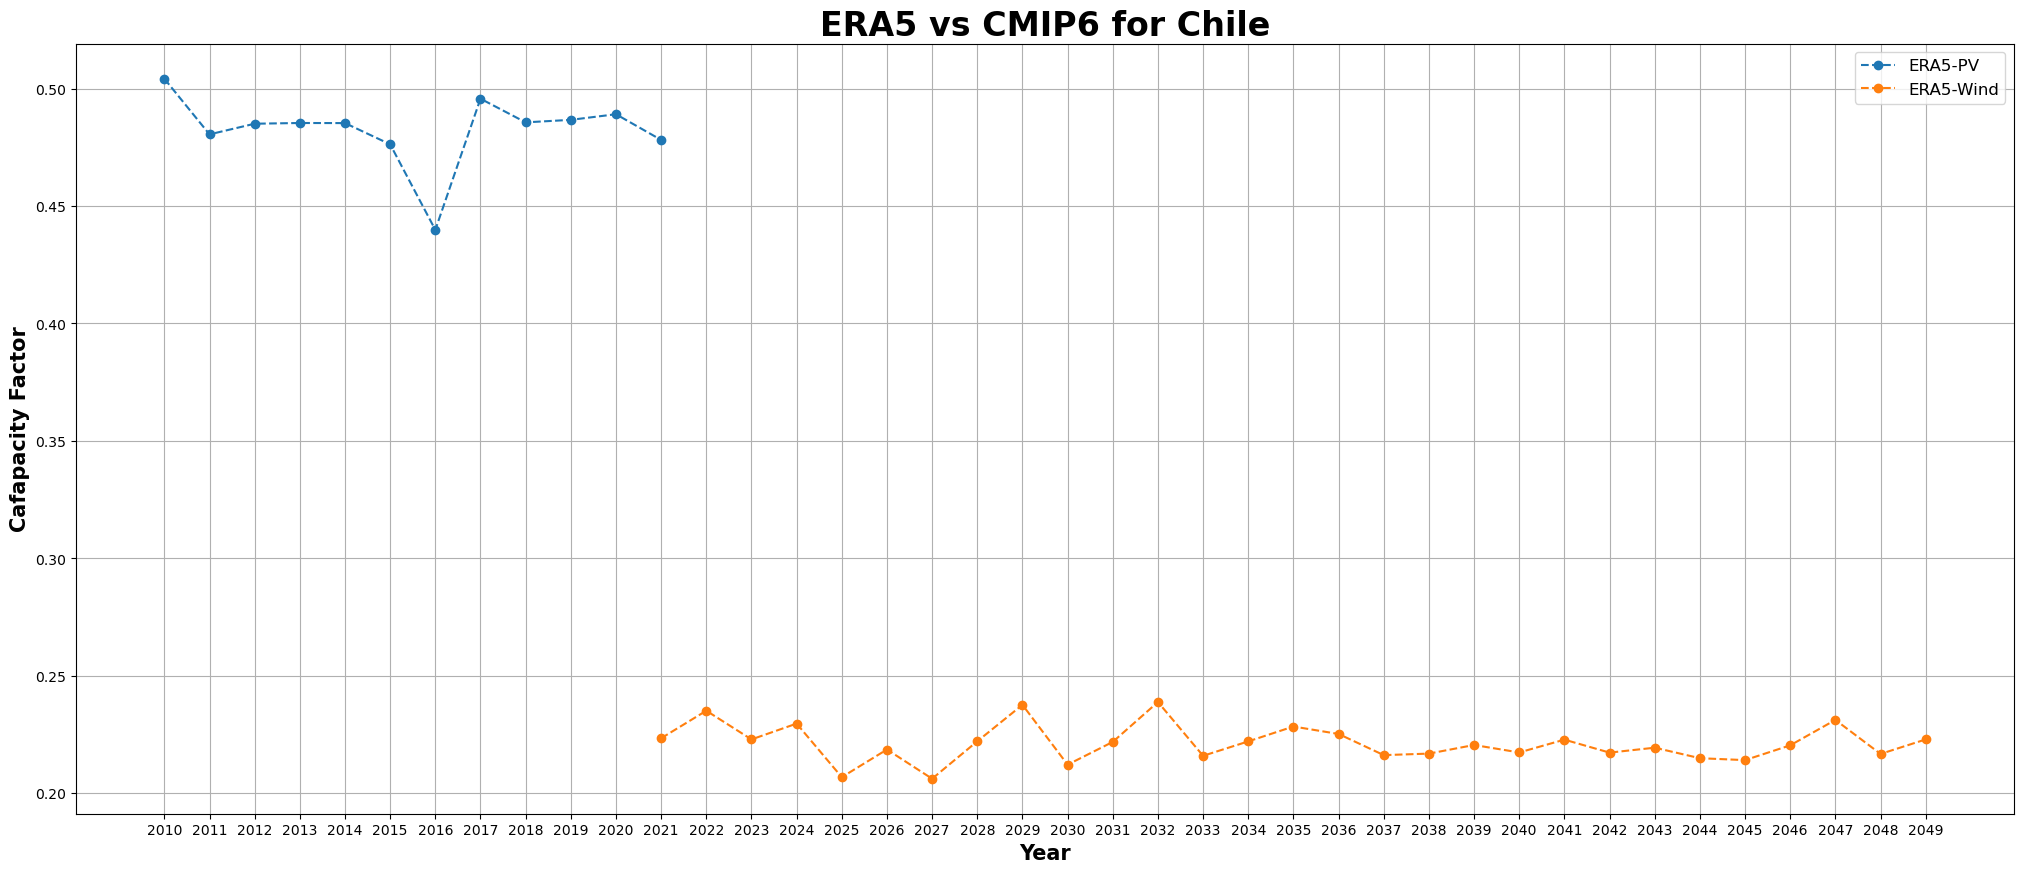

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Modify Zone - see table
zone = "Chile"


era5_file = "era5_CapFact_"+zone+".csv"
cmip_file = "cmip_CapFact_"+zone+".csv"

cf_era5 = pd.read_csv(era5_file, sep=";", index_col="year")
cf_cmip = pd.read_csv(cmip_file, sep=";", index_col="year")


fig, ax = plt.subplots(figsize=(25, 10))
cf_era5.plot(ax=ax, linestyle="dashed", xticks=range(2010,2050), marker='o', grid=True)
cf_cmip.plot(ax=ax, linestyle="dashed", xticks=range(2010,2050), marker='o', grid=True)
ax.set_xlabel("Year", fontsize=15, fontweight="bold")
ax.set_ylabel("Cafapacity Factor", fontsize=15, fontweight="bold")
plt.title("ERA5 vs CMIP6 for "+zone, fontsize=24, fontweight="bold")
ax.legend(["ERA5-PV", "ERA5-Wind", "CMIP6-PV", "CMIP6-Wind"], fontsize=12)

## Only Wind

In [ ]:

import xarray as xr
import atlite
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd

# regions
regions = ["CL-AP", "CL-TA", "CL-AN", "CL-AT", "CL-CO", 
           "CL-RM", "CL-VS", "CL-ML", "CL-LI", "CL-NB",
           "CL-AR", "CL-BI", "CL-LL", "CL-AI", "CL-MA"]

# Shape file for Chile - boundary
Chile = gpd.read_file('Chile.geojson')
Chile = Chile.set_index('region')
bounds = Chile.unary_union.buffer(1).bounds
# set lat and lon
x1 = bounds[0]
y1 = bounds[1]
x2 = bounds[2]
y2 = bounds[3]

Chile = gpd.read_file('Chile.geojson')
# loop to calculate the generation for each region in Chile
for region_name in regions:
    region = Chile[Chile.region==region_name]
    region = region.set_index('region')
    bounds = region.unary_union.buffer(1).bounds
    # set lat and lon
    xx1 = bounds[0]
    yy1 = bounds[1]
    xx2 = bounds[2]
    yy2 = bounds[3]

    # Wind configuration
    turbine_config = atlite.resource.get_windturbineconfig('Vestas_V112_3MW')

    # years for era5 and cmip6
    era5years = range(2010,2022)
    cmipyears = range(2021,2050)

    # Define empty arrays
    wind_era5 = []

    # load ERA5 files
    for year in era5years:
        print(year)
        filename = "./data/era5/Chile_"+str(year)+".nc"
        # read era5 files
        cutout_era5 = atlite.Cutout(path=filename,
                                        module="era5", 
                                        x=slice(x1,x2), 
                                        y=slice(y1,y2), 
                                        time=str(year))
        cutout_era5 = cutout_era5.sel(x=slice(xx1,xx2), y=slice(yy1,yy2))
        # calculate wind generation
        mean_wind, data_wind = cutout_era5.wind(turbine=turbine_config, capacity_factor=True)

        # store generation data
        wind_era5.append(float(data_wind.mean(["x","y","time"])))

    # retrieve roughness from era5 - cmip5 doesn't provide roughness
    roughness = cutout_era5.data["roughness"] # last cutout from era5
    roughness = roughness.to_dataset()
    roughness = roughness.mean(["time"])

    # cmip params
    esgf_params = {
    'data_node': 'esgf.ceda.ac.uk',
    'source_id': 'HadGEM3-GC31-MM',
    'variant_label':'r1i1p1f3',
    'experiment_id': 'ssp126',
    'project' : 'CMIP6'}

    # Define empty arrays
    wind_cmip = []

    for year in cmipyears:
        print(year)
        filename = "./data/cmip-ssp126/cmip_chile_"+str(year)+".nc"
        # read cmip files
        cutout_cmip = atlite.Cutout(path="./data/cmip-ssp126/cmip_chile_"+str(year)+".nc",
                                    module=["cmip"], 
                                    x=slice(x1,x2), 
                                    y=slice(y1,y2), 
                                    time=str(year), 
                                    esgf_params=esgf_params, 
                                    dt='3H', dx=1,dy=1)
        cutout_cmip = cutout_cmip.sel(x=slice(xx1,xx2), y=slice(yy1,yy2))

        # include roughness in cmip structure
        da = roughness.roughness.interp_like(cutout_cmip.data['influx'].isel(time=0))
        cutout_cmip.data = cutout_cmip.data.assign(roughness=da)
        # calculate wind generation
        mean_wind, data_wind = cutout_cmip.wind(turbine=turbine_config, capacity_factor=True)

        # store generation data
        wind_cmip.append(float(data_wind.mean(["x","y","time"])))

    # create dataframe with pv and wind generation data
    cf_era5 = pd.DataFrame({"year":era5years, "Wind":wind_era5})
    cf_cmip = pd.DataFrame({"year":cmipyears, "Wind":wind_cmip})
    cf_era5 = cf_era5.set_index("year")
    cf_cmip = cf_cmip.set_index("year")

    cf_era5.to_csv("era5_CapFact_"+region_name+"_v2.csv", sep=";")
    cf_cmip.to_csv("cmip_CapFact_"+region_name+"_v2.csv", sep=";")

In [ ]:
#from atlite.datasets.era5 import retrieve_data, _rename_and_clean_coords, retrieval_times, _area
#from joblib import Parallel
import xarray as xr
import atlite
#import logging
#import cdsapi
#from cartopy.io import shapereader
#import geopandas as gpd
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#logging.basicConfig(level=logging.INFO)

import geopandas as gpd
import pandas as pd

#from pyesgf.logon import LogonManager

# Shape file for Chile - boundary
Chile = gpd.read_file('Chile.geojson')
Chile = Chile.set_index('region')
bounds = Chile.unary_union.buffer(1).bounds
# set lat and lon
x1 = bounds[0]
y1 = bounds[1]
x2 = bounds[2]
y2 = bounds[3]

# Wind configuration
turbine_config = atlite.resource.get_windturbineconfig('Vestas_V112_3MW')

# years for era5 and cmip6
era5years = range(2010,2022)
cmipyears = range(2021,2050)

# Define empty arrays
wind_era5 = []

# load ERA5 files
for year in era5years:
    print(year)
    filename = "./data/era5/Chile_"+str(year)+".nc"
    # read era5 files
    cutout_era5 = atlite.Cutout(path=filename,
                                    module="era5", 
                                    x=slice(x1,x2), 
                                    y=slice(y1,y2), 
                                    time=str(year))
    # calculate wind generation
    mean_wind, data_wind = cutout_era5.wind(turbine=turbine_config, capacity_factor=True)

    # store generation data
    wind_era5.append(float(data_wind.mean(["x","y","time"])))

# retrieve roughness from era5 - cmip5 doesn't provide roughness
roughness = cutout_era5.data["roughness"] # last cutout from era5
roughness = roughness.to_dataset()
roughness = roughness.mean(["time"])

# cmip params
esgf_params = {
   'data_node': 'esgf.ceda.ac.uk',
   'source_id': 'HadGEM3-GC31-MM',
   'variant_label':'r1i1p1f3',
   'experiment_id': 'ssp126',
   'project' : 'CMIP6'}

# Define empty arrays
wind_cmip = []

for year in cmipyears:
    print(year)
    filename = "./data/cmip-ssp126/cmip_chile_"+str(year)+".nc"
    # read cmip files
    cutout_cmip = atlite.Cutout(path="./data/cmip-ssp126/cmip_chile_"+str(year)+".nc",
                                module=["cmip"], 
                                x=slice(x1,x2), 
                                y=slice(y1,y2), 
                                time=str(year), 
                                esgf_params=esgf_params, 
                                dt='3H', dx=1,dy=1)
    # include roughness in cmip structure
    da = roughness.roughness.interp_like(cutout_cmip.data['influx'].isel(time=0))
    cutout_cmip.data = cutout_cmip.data.assign(roughness=da)
    # calculate wind generation
    mean_wind, data_wind = cutout_cmip.wind(turbine=turbine_config, capacity_factor=True)

    # store generation data
    wind_cmip.append(float(data_wind.mean(["x","y","time"])))

# create dataframe with pv and wind generation data
cf_era5 = pd.DataFrame({"year":era5years, "Wind":wind_era5})
cf_cmip = pd.DataFrame({"year":cmipyears, "Wind":wind_cmip})
cf_era5 = cf_era5.set_index("year")
cf_cmip = cf_cmip.set_index("year")

cf_era5.to_csv("era5_CapFact_Chile_v2.csv", sep=";")
cf_cmip.to_csv("cmip_CapFact_Chile_v2.csv", sep=";")

### Plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Modify Zone - see table
zone = "Chile"

era5_file = "era5_CapFact_"+zone+".csv"
cmip_file = "cmip_CapFact_"+zone+".csv"

era5_file_v2 = "era5_CapFact_"+zone+"_v2.csv"
cmip_file_v2 = "cmip_CapFact_"+zone+"_v2.csv"

cf_era5 = pd.read_csv(era5_file, sep=";", index_col="year")
cf_cmip = pd.read_csv(cmip_file, sep=";", index_col="year")

cf_era5_v2 = pd.read_csv(era5_file_v2, sep=";", index_col="year")
cf_cmip_v2 = pd.read_csv(cmip_file_v2, sep=";", index_col="year")


fig, ax = plt.subplots(figsize=(25, 10))
cf_era5.plot(ax=ax, linestyle="dashed", xticks=range(2010,2050), marker='o', grid=True)
cf_cmip.plot(ax=ax, linestyle="dashed", xticks=range(2010,2050), marker='o', grid=True)
cf_era5_v2.plot(ax=ax, linestyle="dashed", xticks=range(2010,2050), marker='o', grid=True)
cf_cmip_v2.plot(ax=ax, linestyle="dashed", xticks=range(2010,2050), marker='o', grid=True)
ax.set_xlabel("Year", fontsize=15, fontweight="bold")
ax.set_ylabel("Cafapacity Factor", fontsize=15, fontweight="bold")
plt.title("ERA5 vs CMIP6 for "+zone, fontsize=24, fontweight="bold")
ax.legend(["ERA5-PV", "ERA5-Wind", "CMIP6-PV", "CMIP6-Wind", "ERA5-Wind v2", "CMIP6-Wind v2"], fontsize=12)